In [50]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import lcurve_corner as lc
from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Define local functions
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

def solveBP(X, y, p_basis, max_iters = 20, lambda_reg = 0, OptTol = 1e-3):

    """
    SolveBP: Solves a Basis Pursuit problem
    Usage
    ----------------------------------------------------------------------
    sol = SolveBP(X, y, N, max_iters, lambda_reg, OptTol)

    Input
    ----------------------------------------------------------------------
    A:             Either an explicit nxN matrix, with rank(A) = min(N,n) 
                   by assumption, or a string containing the name of a 
                   function implementing an implicit matrix.
                   vector of length n.
                   length of solution vector. 

    max_iters:     maximum number of PDCO iterations to perform, default 20.
    lambda_reg:    If 0 or omitted, Basis Pursuit is applied to the data, 
                   otherwise, Basis Pursuit Denoising is applied with 
                   parameter lambda (default 0). 
    OptTol:        Error tolerance, default 1e-3

    Outputs
    ----------------------------------------------------------------------
    sol             solution of BP

    Description

    SolveBP solves the Basis Pursuit Denoising (BPDN) problem

    min  1/2||b - A*x||_2^2 + lambda*||x||_1

    using the library cvxpy  
    """

    beta = cp.Variable(p_basis)
    lambd = cp.Parameter(nonneg=True)
    problem = cp.Problem(cp.Minimize(objective_fn(X, y, beta, lambd)))
    lambd.value = lambda_reg
    problem.solve()
    sol = beta.value

    return sol

def menger(P1, P2, P3):
    
    u = P1 - P2
    v = P3 - P2

    return 2 * (v[0] * u[1] - u[0] * v[1]) / ( norm(u) * norm(v) * norm(u - v) )

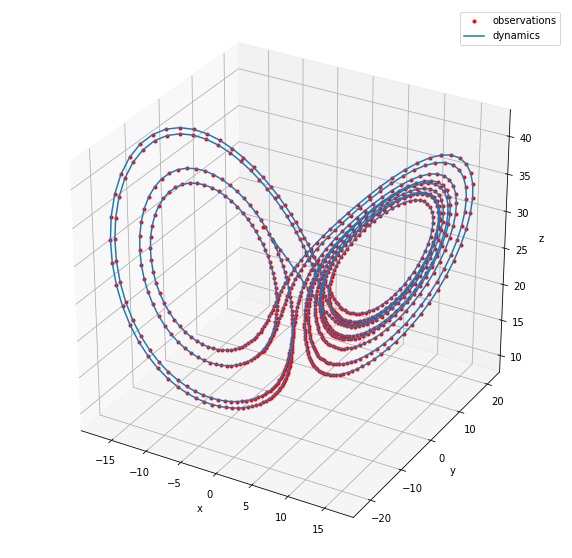

In [51]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def lorenz63(x, t, sigma=10, rho=28, beta=8/3):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ]

sig=10
rho=28
beta=8/3


####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 3 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [-8, 7, 27]
X = odeint(lorenz63, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = sig * (x2 - x1)
dX[:,1] =  x1 * (rho - x3) - x2
dX[:,2] = x1 * x2 - beta * x3

dY = dX + 0.05*np.random.randn(n_times,n_states)

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]
y3 = Y[:,2]

#Plot dynamical system and observations
plt.figure(figsize = (10,10))
ax = plt.axes(projection="3d")
ax.plot3D(y1,y2,y3,'r.')
ax.plot3D(x1[1:],x2[1:],x3[1:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(['observations','dynamics'])
plt.show()

In [52]:
# SET UP LINEAR ALGEBRA PROBLEM

#Model to approximate functions f1 = dx1 and f2 = dx2
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(Y)
basis_names = poly.get_feature_names()
p_basis = Phi.shape[1]#Number of basis functions

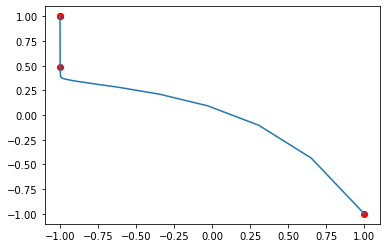

In [67]:
n_lambdas = 50
lambdas = np.logspace(-10,1,n_lambdas)

#Normalize columns of X
c_norm = np.linalg.norm(Phi, axis=0)
Wn = np.diag(1 / c_norm)
Phin = np.dot(Phi, Wn)#column-normalized X
p_basis = Phin.shape[1]
y = dY[:,0]


pGS = (1 + np.sqrt(5))/2 #Golden search parameter
lambdas_c = [np.min(lambdas), np.max(lambdas), 0, 0]
lambdas_c[2] = np.exp( (np.log(lambdas_c[1]) + pGS * np.log(lambdas_c[0])) / (1 + pGS) ) 
lambdas_c[3] = np.exp( np.log(lambdas_c[0]) + np.log(lambdas_c[1]) - np.log(lambdas_c[2]) )

xis = np.zeros(4)
etas = np.zeros(4)

for s in range(4):

    current_lambda = lambdas_c[s]

    #Solve BPDN with current lambda

    beta_tilde = solveBP(Phin, y, p_basis, lambda_reg = current_lambda)
    beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

    residual = norm(np.dot(Phi, beta) - y)
    reg_residual = norm(beta_tilde, ord = 1)
    xis[s] = np.log(residual) 
    etas[s] = np.log(reg_residual) 

# #Normalize between -1 and 1

cxi0 = 1 - 2/(xis[1] - xis[0])*xis[1]
cxi1 = 2 / (xis[1] - xis[0]);
ceta0 = 1 - 2/(etas[0] - etas[1])*etas[0]
ceta1 = 2 / (etas[0] - etas[1])

xis = cxi0 + cxi1 * xis
etas = ceta0 + ceta1 * etas

P = np.array([[xis[0],xis[1],xis[2],xis[3]], [etas[0],etas[1],etas[2],etas[3]]])   
indx = np.argsort(lambdas_c)
P = P[:,indx]

xis2 = np.zeros(n_lambdas)
etas2 = np.zeros(n_lambdas)

for s,lambda_s in enumerate(lambdas):    
    #Solve BPDN with current lambda

    beta_tilde = solveBP(Phin, y, p_basis, lambda_reg = lambda_s)
    beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

    residual = norm(np.dot(Phi, beta) - y)
    reg_residual = norm(beta_tilde, ord = 1)

    xis2[s] = np.log(residual) 
    etas2[s] = np.log(reg_residual) 

#Normalize between -1 and 1
xis2 = cxi0 + cxi1 * xis2
etas2 = ceta0 + ceta1 * etas2


plt.plot(P[0,:],P[1,:],'ro')
plt.plot(xis2, etas2)

Stopping criterion reached in 37 iterations.


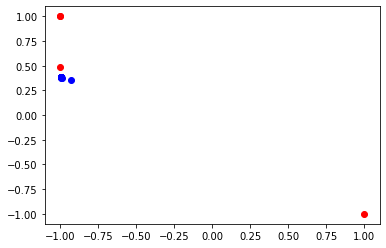

In [86]:

X = Phi
y = dY[:,0]
lambda_min = 1e-10
lambda_max = 10
epsilon = 0.0000001
max_iter = 50
    
    
pGS = (1 + np.sqrt(5))/2 #Golden search parameter
gap = 1
itr = 0
lambda_itr = []

lambda_vec = np.array([lambda_min, lambda_max, 0, 0])
lambda_vec[2] = np.exp( (np.log(lambda_vec[1]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 
lambda_vec[3] = np.exp( np.log(lambda_vec[0]) + np.log(lambda_vec[1]) - np.log(lambda_vec[2]) )

xis = np.zeros(4)
etas = np.zeros(4)
lc_xi = []
lc_eta = []

#Normalize columns of X
c_norm = np.linalg.norm(X, axis=0)
Wn = np.diag(1 / c_norm)
Xn = np.dot(X, Wn)#column-normalized X
p_basis = Xn.shape[1]

while (gap >= epsilon) and (itr <= max_iter):

    if itr == 0:

        for s in range(4):

            current_lambda = lambda_vec[s]

            #Solve BPDN with current lambda

            beta_tilde = solveBP(Xn, y, p_basis, lambda_reg = current_lambda)
            beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

            residual = norm(np.dot(X, beta) - y)
            reg_residual = norm(beta_tilde, ord = 1)

            xis[s] = np.log(residual) 
            etas[s] = np.log(reg_residual) 

        #Normalize between -1 and 1

        cxi0 = 1 - 2/(xis[1] - xis[0])*xis[1]
        cxi1 = 2 / (xis[1] - xis[0]);
        ceta0 = 1 - 2/(etas[0] - etas[1])*etas[0]
        ceta1 = 2 / (etas[0] - etas[1])

        xis = cxi0 + cxi1 * xis
        etas = ceta0 + ceta1 * etas

        lc_xi.append(xis)
        lc_eta.append(etas)

        P = np.array([[xis[0],xis[1],xis[2],xis[3]], [etas[0],etas[1],etas[2],etas[3]]])           
        indx = np.argsort(lambda_vec)
        
        #Sort lambdas
        lambda_vec = lambda_vec[indx]
        P = P[:,indx]
        
        plt.plot(P[0,:],P[1,:],'ro')
        
    #CODE VERIFIED UP TO THIS POINT-------------------------------------------------------------------------------

    # Compute curvatures of the current points
    C2 = menger(P[:,0], P[:,1], P[:,2])
    C3 = menger(P[:,1], P[:,2], P[:,3])

    # Check if the curvature is negative and update values
    while C3 < 0:
        
        #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
        lambda_vec[3] = lambda_vec[2]
        P[:,3] = P[:,2]
        lambda_vec[2] = lambda_vec[1]
        P[:,2] = P[:,1]

        #Update interior lambda and interior point
        lambda_vec[1] = np.exp( (np.log(lambda_vec[3]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 

        #Solve for lambda_1
        beta_tilde = solveBP(Xn, y, p_basis, lambda_reg = lambda_vec[1])
        beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

        residual = norm(np.dot(X, beta) - y)
        reg_residual = norm(beta_tilde, ord = 1)

        xi = cxi0 + cxi1 * np.log(residual)
        eta = ceta0 + ceta1 * np.log(reg_residual)

        #Normalize curve
        P[:,1] = [xi,eta]

        C3 = menger(P[:,1], P[:,2], P[:,3])

    # Update values depending on the curvature at the new points
    if C2 > C3:
        
        current_lambda = lambda_vec[1]

        #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
        lambda_vec[3] = lambda_vec[2]
        P[:,3] = P[:,2]

        lambda_vec[2] = lambda_vec[1]
        P[:,2] = P[:,1]

        #Update interior lambda and interior point
        lambda_vec[1] = np.exp( (np.log(lambda_vec[3]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 

        #Solve for lambda_1
        beta_tilde = solveBP(Xn, y, p_basis, lambda_reg = lambda_vec[1])
        beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

        residual = norm(np.dot(X, beta) - y)
        reg_residual = norm(beta_tilde, ord = 1)

        xi = cxi0 + cxi1 * np.log(residual)
        eta = ceta0 + ceta1 * np.log(reg_residual)

        P[:,1] = [xi,eta]

    else:
        
        current_lambda = lambda_vec[2]

        #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
        lambda_vec[0] = lambda_vec[1]
        P[:,0] = P[:,1]

        lambda_vec[1] = lambda_vec[2]
        P[:,1] = P[:,2]

        #Update interior lambda and interior point
        lambda_vec[2] = np.exp( np.log(lambda_vec[0]) + np.log(lambda_vec[3]) - np.log(lambda_vec[1]) )
        
        #Solve for lambda_2
        beta_tilde = solveBP(Xn, y, p_basis, lambda_reg = lambda_vec[2])
        beta = np.dot(Wn, beta_tilde)#De-normalize coefficients

        residual = norm(np.dot(X, beta) - y)
        reg_residual = norm(beta_tilde, ord = 1)

        xi = cxi0 + cxi1 * np.log(residual)
        eta = ceta0 + ceta1 * np.log(reg_residual)

        P[:,2] = [xi,eta]

    gap = ( lambda_vec[3] - lambda_vec[0] ) / lambda_vec[3]
    
    if gap < epsilon:
        print(f'Stopping criterion reached in {itr} iterations.')
        
    lambda_itr.append(current_lambda)

    lc_xi.append(xi)
    lc_eta.append(eta)
        
    itr += 1
    
    if itr == max_iter:
        print(f'Maximum number of {itr} iterations reached.')
    

#lambda_corner = current_lambda